# Single cell analysis

In [1]:
import numpy as np
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation
import glob
import os, datetime
from pathlib import Path
from matplotlib import pyplot as plt
import sys
import pandas as pd
import plotly.express as px
import skimage
import numpy

print(numpy.__version__)
print(skimage.__version__)
print(sc.__version__)

# sc.settings.verbosity = 0
# sc.settings.set_figure_params(
#    dpi=80,
#    facecolor="white",
#    frameon=False,
# )

In [ ]:
!date

In [ ]:
# sample_ids

# sample_name = "BK23-SKI-27-FT-1b_mG"
# sample_id = "WS_wEMB10202354"
sample_id = ""
sanger_id = ""
# sample_id = sanger_id
sample_name = ""  # Not presently used in the notebook
cellranger_folder_path = "/lustre/scratch124/cellgen/haniffa/data/samples/WS_wEMB10202354/cellranger/cellranger601_count_37876_WS_wEMB10202354_GRCh38-2020-A/"
cellranger_folder = cellranger_folder_path
# Paths
outpt_folder_path = os.path.join("./", "rna_scanpy")

'/lustre/scratch124/cellgen/haniffa/projects/fs_regional_id/nobackup_data/cellranger/HCA_rFSKI15175612'

In [93]:
# --- Sushi Color Palette ---
SUSHI_COLORS = {
    "orange": "#D28140",
    "light_gray": "#DCD7D5",
    "beige": "#E6CDAE",
    "off_white": "#F8F8F8",
    "navy": "#33475B",
}

# --- Sushi Vibrant Dashboard Theme (Navy headers, Orange accents) ---
BOOTSTRAP_STYLES = f"""
<link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.2/dist/css/bootstrap.min.css" rel="stylesheet">

<style>

body {{
  background-color: {SUSHI_COLORS['off_white']};
  font-family: 'Open Sans', sans-serif;
  padding-bottom: 2rem;
}}

header {{
  background-color: {SUSHI_COLORS['navy']};
  color: white;
  padding: 1.3rem;
  border-radius: 12px;
  margin-bottom: 1.8rem;
  text-align: center;
}}

h1, h2, h3, h4, h5 {{
  font-weight: 600;
}}

.card {{
  border-radius: 12px;
  border: 1px solid {SUSHI_COLORS['light_gray']};
  box-shadow: 0 3px 8px rgba(0,0,0,0.08);
}}

.card-header {{
  background-color: {SUSHI_COLORS['navy']};
  color: white;
  font-weight: bold;
  border-radius: 12px 12px 0 0;
}}

.btn-primary {{
  background-color: {SUSHI_COLORS['orange']};
  border-color: {SUSHI_COLORS['orange']};
}}

.btn-primary:hover {{
  background-color: {SUSHI_COLORS['navy']};
  border-color: {SUSHI_COLORS['navy']};
}}

.btn-outline-secondary {{
    border-color: {SUSHI_COLORS['orange']};
    color: {SUSHI_COLORS['orange']};
}}

.btn-outline-secondary:hover {{
    background-color: {SUSHI_COLORS['orange']};
    color: white;
}}

.table thead th {{
  background-color: {SUSHI_COLORS['navy']};
  color: white;
}}

footer {{
  margin-top: 2rem;
  text-align: center;
  color: #666;
  font-size: 0.9rem;
}}

</style>
"""

In [2]:
# os.environ["HLBI_PIPE_BASEDIR"] = (
#     "/lustre/scratch126/cellgen/team298/vm11/PROJECTS/PIPELINE/Haniffa-utils/"
# )

In [3]:
# !cat scanpy_rna_config.py

gex_only = True
sim_doublet_ratio = 5
min_cells_cutoff = 50  # min number of cells a gene is present for it to be realised


In [4]:
# Importing config file
# %reload_ext scanpy_rna_config
# if os.path.exists("scanpy_rna_config.py"):
#    print("Reading user config file")
#    from scanpy_rna_config import *
# else:
#    print("Reading global config file")
#    sys.path.append(os.path.join(os.environ['HLBI_PIPE_BASEDIR'], 'bin', 'nb'))
#    from scanpy_rna_config import *

## User input values


In [4]:
# QC params

gex_only = True

# pre-QC cutoffs  = To remove really bad cells. So cutoffs are very permissive
min_total_counts = 100
min_genes_counts = 50
max_mt_pct = 75

# scrublet options
sim_doublet_ratio = 5
threshold = 0.7

# qc threshholds
nmads = 5

min_total_counts_qc_threshold = 100  # can also add max threshold
min_genes_counts_qc_threshold = 100
max_mt_pct_counts_qc_threshold = 20
doublet_col = (
    "predicted_doublet_3MAD"  #  predicted_doublet_scrublet or predicted_doublet_5MAD
)

# normalisation target_sum
target_sum = 10000

# hvg calculation
n_top_genes = 2000

# UMAP RELATED
n_comps = 50  # pca
n_pcs = 50  # kNN
resolution = 1  # leiden
min_dist = 0.5  # UMAP
spread = 1  # UMAP

In [107]:
# -------------------------------------------------------
# Functions for scanpy
# -------------------------------------------------------


def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier


def create_html_page(title, plot_path, output_dir, plot_type="individual", prefix=None):
    """
    Create a single self-contained HTML page with Sushi CSS and embedded plot content.
    Adds responsive handling and centers Plotly/Altair plots inside the card.
    """
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

    # Determine output filename
    base_name = os.path.splitext(os.path.basename(plot_path))[0]

    # IMPORTANT: use double underscore to safely separate sample and plot name
    if prefix:
        base_name = f"{prefix}__{base_name}"

    output_name = f"{base_name}_{plot_type}.html"
    output_path = os.path.join(output_dir, output_name)

    # Read plot HTML
    with open(plot_path, "r") as f:
        plot_html = f.read()

    # Responsive + centering CSS
    responsive_css = """
    <style>
      .plot-wrapper {
          display: flex;
          justify-content: center;
          align-items: center;
          overflow-x: auto;
          -webkit-overflow-scrolling: touch;
      }
      .plot-wrapper .plot-container,
      .plot-wrapper .js-plotly-plot,
      .plot-wrapper .plotly,
      .plot-wrapper .main-svg {
          max-width: 100% !important;
          width: 100% !important;
          height: auto !important;
      }
    </style>
    """

    # Build HTML page
    html_content = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
      <meta charset="UTF-8">
      <title>{title}</title>
      {BOOTSTRAP_STYLES}
      {responsive_css}
    </head>
    <body>
      <div class="container py-4">
        <header>
          <h2>{title}</h2>
        </header>

        <div class="card p-3 mb-4">
          <div class="plot-wrapper">
            {plot_html}
          </div>
        </div>

        <a href="index.html" class="btn btn-primary">⬅ Back to Index</a>

        <footer>
          <p class="mt-3 text-muted">Generated on {timestamp}</p>
        </footer>
      </div>
    </body>
    </html>
    """

    with open(output_path, "w") as f:
        f.write(html_content)


# Keywords that indicate start of plot name
PLOT_KEYWORDS = [
    "umap",
    "pca",
    "qc",
    "hvg",
    "violin",
    "doublet",
    "embedding",
    "histogram",
    "scatter",
    "metrics",
]


def extract_sample_id(filename):
    """
    Extracts sample ID from a *_individual.html filename
    by detecting where the plot name begins.
    Works with ANY sample formatting, including underscores.
    """
    base = filename.replace("_individual.html", "")
    parts = base.split("_")

    # Detect start of plot name
    for i, part in enumerate(parts):
        if part.lower() in PLOT_KEYWORDS:
            return "_".join(parts[:i])

    # fallback: everything except the last token
    return "_".join(parts[:-1])


def build_sample_pages(report_dir):
    """
    Builds one 'sample overview' HTML file per sample,
    grouping all *_individual.html plots using robust sample ID extraction.
    """
    all_html = [f for f in os.listdir(report_dir) if f.endswith("_individual.html")]

    if not all_html:
        print(" No *_individual.html files found — nothing to build.")
        return

    sample_groups = {}

    for fname in all_html:
        sample = extract_sample_id(fname)
        sample_groups.setdefault(sample, []).append(fname)

    # Reusable responsive CSS
    responsive_css = """
    <style>
      .responsive-plot {
          display: flex;
          justify-content: center;
          align-items: center;
          overflow-x: auto;
          -webkit-overflow-scrolling: touch;
      }
      .responsive-plot .plot-container,
      .responsive-plot .js-plotly-plot,
      .responsive-plot .plotly,
      .responsive-plot .main-svg {
          max-width: 100% !important;
          width: 100% !important;
          height: auto !important;
      }
    </style>
    """

    for sample, files in sample_groups.items():

        embedded_plots = ""
        for f in sorted(files):
            with open(os.path.join(report_dir, f)) as pf:
                plot_html = pf.read()

            clean_title = f.replace("_individual.html", "")
            clean_title = clean_title.replace(sample + "__", "")

            embedded_plots += f"""
            <div class="card p-3 mb-4 text-center">
                <h4>{clean_title}</h4>
                <div class="responsive-plot">{plot_html}</div>
            </div>
            """

        out_name = f"{sample}_sample_overview.html"
        out_path = os.path.join(report_dir, out_name)

        html_content = f"""
        <!DOCTYPE html>
        <html lang="en">
        <head>
            <meta charset="UTF-8">
            <title>{sample} QC Overview</title>
            {BOOTSTRAP_STYLES}
            {responsive_css}
        </head>
        <body>
            <div class="container py-4">
                <header><h2>{sample} — QC Overview</h2></header>
                {embedded_plots}
                <a href="../index.html" class="btn btn-primary">⬅ Back to Index</a>
            </div>
        </body>
        </html>
        """

        with open(out_path, "w") as f:
            f.write(html_content)

        print(f" Created sample overview: {out_name}")


def build_index_page(report_dir, project_name="Solosis ", overview_rows=None):
    """
    Recursively discovers per-sample overview pages and general pages,
    then builds a Sushi-themed index.html with correct relative links.
    """
    os.makedirs(report_dir, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

    sample_pages = []
    general_pages = []

    for root, dirs, files in os.walk(report_dir):
        for f in files:
            if not f.endswith(".html"):
                continue
            if f == "index.html":
                continue

            full = os.path.join(root, f)
            rel = os.path.relpath(full, report_dir)

            if f.endswith("_sample_overview.html"):
                sample_pages.append(rel)
            elif f.endswith("_general.html"):
                general_pages.append(rel)

    general_links = [
        f'<a href="{p}" class="btn btn-outline-primary m-1">{os.path.basename(p).replace("_general.html", "")}</a>'
        for p in sorted(general_pages)
    ]

    individual_links = [
        f'<a href="{p}" class="btn btn-outline-secondary m-1">{os.path.basename(p).replace("_sample_overview.html", "")}</a>'
        for p in sorted(sample_pages)
    ]

    overview_html = ""
    if overview_rows:
        rows_html = "\n".join(
            [
                f"<tr><td>{r['sample']}</td><td>{r['before']}</td><td>{r['after']}</td><td>{r['retention']:.2f}%</td></tr>"
                for r in overview_rows
            ]
        )
        overview_html = f"""
        <div class="card mb-4">
            <div class="card-header" style="background-color:{SUSHI_COLORS['orange']};color:white;">Overview</div>
            <div class="card-body">
                <table class="table table-striped table-hover">
                    <thead><tr><th>Sample</th><th>Cells Before QC</th><th>Cells After QC</th><th>Retention %</th></tr></thead>
                    <tbody>{rows_html}</tbody>
                </table>
            </div>
        </div>
        """

    html = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <title>{project_name} QC Report</title>
        {BOOTSTRAP_STYLES}
    </head>
    <body>
        <div class="container py-4">
            <header>
                <h1>{project_name}  Report</h1>
                <p class="text-light">Generated on {timestamp}</p>
            </header>

            {overview_html}

            <div class="card mb-4">
                <div class="card-header" style="background-color:{SUSHI_COLORS['orange']};color:white;">General Plots</div>
                <div class="card-body d-flex flex-wrap">
                    {"".join(general_links) if general_links else "<p>No general plots found.</p>"}
                </div>
            </div>

            <div class="card mb-4">
                <div class="card-header" style="background-color:{SUSHI_COLORS['navy']};color:white;">Per-Sample Reports</div>
                <div class="card-body d-flex flex-wrap">
                    {"".join(individual_links) if individual_links else "<p>No per-sample pages found.</p>"}
                </div>
            </div>
        </div>
    </body>
    </html>
    """

    with open(os.path.join(report_dir, "index.html"), "w") as f:
        f.write(html)

# Loading data

In [8]:
samples_database = "/lustre/scratch124/cellgen/haniffa/data/samples"
sample_name = "BK23-SKI-27-FT-1b_mG"
sample_id = "HCA_SkO15052460"
cellranger_folder = "cellranger-dff"

Data HCA_rFSKI15175612 loaded successfully. Data shape is (975, 38606) 



/software/cellgen/team298/bf16/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/software/cellgen/team298/bf16/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Reading file

In [ ]:
# Read file
outpt_folder = os.path.join(samples_database, sample_id, "scanpy")
os.makedirs(outpt_folder, exist_ok=True)

cranger_folder = os.path.join(samples_database, sample_id, cellranger_folder)
adata = sc.read_10x_h5(h5_file, gex_only=gex_only)
adata.var_names_make_unique()

print(
    "\033[1m"
    + f"Data {sample_id} loaded successfully. Data shape is {adata.shape}"
    + "\033[0m",
    "\n",
)

In [108]:
# Create report + plot directories
report_dir = f"./reports/{sample_id}"
plot_dir = os.path.join(report_dir, "plots")

os.makedirs(report_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

print(f"Saving plots to: {plot_dir}")

Saving plots to: ./reports/HCA_rFSKI15175612/plots


In [14]:
adata.obs["sanger_id"] = sample_id
adata.obs.index = (
    adata.obs.index + "_" + sample_id
)  # if sample_name is there we can add sample name as well as obs column

In [15]:
adata.obs.head()

,sanger_id
AAACCAGCACTCCTAC-1_HCA_rFSKI15175612,HCA_rFSKI15175612
AAACCGGAGCACCACG-1_HCA_rFSKI15175612,HCA_rFSKI15175612
AAACCGGAGCTTGAAT-1_HCA_rFSKI15175612,HCA_rFSKI15175612
AAACCTGTCAGTCAGC-1_HCA_rFSKI15175612,HCA_rFSKI15175612
AAACGCACAGTTACTA-1_HCA_rFSKI15175612,HCA_rFSKI15175612


#  Calculating QC metrics

In [16]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [17]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

In [19]:
adata.obs.columns

Index(['sanger_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'pct_counts_in_top_20_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo',
       'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'],
      dtype='object')

#  Removing very bad quality cells

In [20]:
low_counts = adata.obs["total_counts"] <= min_total_counts
low_genes = adata.obs["n_genes_by_counts"] <= min_genes_counts
high_mt = adata.obs["pct_counts_mt"] >= max_mt_pct

In [21]:
mask_low_qual = (low_counts) | (low_genes) | (high_mt)

In [22]:
print("\n" + "=" * 50)
print("preQC SUMMARY")
print("=" * 50)

n_total = adata.n_obs
n_remove = mask_low_qual.sum()
n_keep = (~mask_low_qual).sum()


print("\n--- Filtering Thresholds ---")
print(f"Min total counts: {min_total_counts}")
print(f"Min genes: {min_genes_counts}")
print(f"Max MT%: {max_mt_pct}")

print(f"\n Total cells before preQC : {n_total}")


print("\n--- Cells failing filtering criteria: ---")

print("Cells with low total_counts:", low_counts.sum())
print("Cells with low n_genes:", low_genes.sum())
print("Cells with high MT%:", high_mt.sum())

print("\n--- Cells failing multiple criteria: --- ")

print("Low counts + Low genes:", (low_counts & low_genes).sum())
print("Low counts + High MT%:", (low_counts & high_mt).sum())
print("Low genes + High MT%:", (low_genes & high_mt).sum())
print("All three:", (low_counts & low_genes & high_mt).sum())
print("Any three:", (low_counts | low_genes | high_mt).sum())

# Show overlap
overlap = (low_counts & low_genes & high_mt).sum()
if overlap > 0:
    print(f"Cells failing all 3 criteria: {overlap}")


preQC SUMMARY

--- Filtering Thresholds ---
Min total counts: 100
Min genes: 50
Max MT%: 75

 Total cells before preQC : 975

--- Cells failing filtering criteria: ---
Cells with low total_counts: 0
Cells with low n_genes: 12
Cells with high MT%: 7

--- Cells failing multiple criteria: --- 
Low counts + Low genes: 0
Low counts + High MT%: 0
Low genes + High MT%: 1
All three: 0
Any three: 18


In [ ]:
# cells to remove
removed_cells_df = adata.obs[mask_low_qual].copy()

# filtering the cells
adata_filt = adata[~mask_low_qual, :].copy()

# Call to_json() on the DataFrame directly
jsonfile = f"{outpt_folder_path}/low_quality_cells_removed_in_preQC_{sample_id}.json"
removed_cells_df.to_json(jsonfile, orient="index", indent=2)


print("\nCriteria use for filtering")
print("=" * 50 + "\n")
print("mask_low_qual = ( (low_counts) | (low_genes) | (high_mt)")


print("=" * 50 + "\n")
print(f"Low-quality cells flagged: {n_remove} ({n_remove/n_total*100:.1f}%)")
print(f"   ├─ Low total counts (≤{min_total_counts}): {low_counts.sum()}")
print(f"   ├─ Low gene counts (≤{min_genes_counts}): {low_genes.sum()}")
print(f"   └─ High MT% (≥{max_mt_pct}%): {high_mt.sum()}")

print(f"\n High-quality cells retained: {n_keep} ({n_keep/n_total*100:.1f}%)")
print("=" * 50 + "\n")

print(f"\n Removed files written to Path: {jsonfile}")

In [ ]:
removed_df = pd.read_json(jsonfile, orient="index")
removed_ids = removed_df.index.tolist()
removed_ids

# Running doublet detetction - scrublet


In [25]:
sc.pp.scrublet(
    adata_filt,
    batch_key=None,
    expected_doublet_rate=0.05,
    threshold=None,
    sim_doublet_ratio=sim_doublet_ratio,
    verbose=True,
)

In [26]:
print(
    f"Total doublets predicted = {adata_filt.obs['predicted_doublet'].value_counts()}"
)

Total doublets predicted = predicted_doublet
False    957
Name: count, dtype: int64


In [27]:
# Saving default doublets predicted by the scrublet

adata_filt.obs["predicted_doublet_scrublet"] = adata_filt.obs[
    "predicted_doublet"
].copy()

In [28]:
# doublets by 3 MAD and 5MAD

adata_filt.obs["predicted_doublet_3MAD"] = is_outlier(
    adata_filt, "doublet_score", nmads=3
)

In [29]:
adata_filt.obs["predicted_doublet_3MAD"].sum()

np.int64(17)

In [30]:
adata_filt.obs["predicted_doublet_5MAD"] = is_outlier(
    adata_filt, "doublet_score", nmads=5
)
adata_filt.obs["predicted_doublet_5MAD"].sum()

np.int64(3)

### Quality Control (QC) Recommendations for Single-Cell RNA-seq



#### 1. **sc-best-practices Approach** (Statistical/MAD-based)
Source: [sc-best-practices.org](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html)

General Outlier Detection (5 MADs threshold)
Flag cells as outliers based on **Median Absolute Deviation (MAD)**:
- `log1p_total_counts` (total UMI counts per cell)
- `log1p_n_genes_by_counts` (number of genes detected)
- `pct_counts_in_top_20_genes` (concentration of counts)
```python
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
```

**Rationale**: MAD-based thresholds adapt to the specific dataset distribution.

#### Mitochondrial Content Filter (3 MADs + hard threshold)
- Use **3 MADs** for `pct_counts_mt` (more stringent than general metrics)
- Apply **hard threshold**: remove cells with >8% mitochondrial content
```python
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
```

**Rationale**: High MT% indicates dying/stressed cells; combining MAD + hard cutoff catches both statistical outliers and biologically compromised cells.

---

#### 2. **Scanpy Tutorial Approach** (Fixed thresholds)
Source: [Scanpy Clustering Tutorial](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering-2017.html)

#### Hard Thresholds
- **Minimum genes per cell**: 200
- **Maximum genes per cell**: 2,500
- **Maximum MT%**: 5%
- **Minimum cells per gene**: 3
```python
# Filter genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Filter cells
adata = adata[
    (adata.obs.n_genes_by_counts < 2500) & 
    (adata.obs.n_genes_by_counts > 200) & 
    (adata.obs.pct_counts_mt < 5),
    :
].copy()
```

**Rationale**: Simple, interpretable thresholds; works well for standard 10x datasets (PBMCs, etc.).

---

#### 3. **Key Differences** (suggested by chatgpt)

| Aspect | sc-best-practices | Scanpy Tutorial |
|--------|-------------------|-----------------|
| **Approach** | Statistical (MAD-based) | Fixed thresholds |
| **Adaptability** | Dataset-specific | Universal values |
| **MT% threshold** | 8% (lenient) | 5% (stringent) |
| **Gene count range** | Adaptive | 200-2,500 |
| **Pros** | Robust to batch effects | Simple, reproducible |
| **Cons** | Requires more computation | May not suit all datasets |



In [ ]:
adata

#  Tagging overall QC metrics 

In [31]:
adata_filt.obs["outlier"] = is_outlier(
    adata_filt, "total_counts", nmads=nmads
) | is_outlier(adata_filt, "n_genes_by_counts", nmads=nmads)

adata_filt.obs["outlier_total_counts"] = is_outlier(
    adata_filt, "total_counts", nmads=nmads
)
adata_filt.obs["outlier_genes_counts"] = is_outlier(
    adata_filt, "n_genes_by_counts", nmads=nmads
)
adata_filt.obs["outlier_pct_counts_mt"] = is_outlier(
    adata_filt, "pct_counts_mt", nmads=nmads
)

# extra
adata_filt.obs["outlier_pct_counts_ribo"] = is_outlier(
    adata_filt, "pct_counts_ribo", nmads=nmads
)
adata_filt.obs["outlier_pct_counts_hb"] = is_outlier(
    adata_filt, "pct_counts_hb", nmads=nmads
)


print(f" Total outliers present in samples = {adata_filt.obs['outlier'].sum()}")

print(f" outliers- total_counts = {adata_filt.obs['outlier_total_counts'].sum()}")
print(f" outliers- genes_counts = {adata_filt.obs['outlier_genes_counts'].sum()}")
print(f" outliers- pct_mt = {adata_filt.obs['outlier_pct_counts_mt'].sum()}")
print(f" outliers- pct_ribo = {adata_filt.obs['outlier_pct_counts_ribo'].sum()}")
print(f" outliers- pct_hb = {adata_filt.obs['outlier_pct_counts_hb'].sum()}")

 Total outliers present in samples = 229
 outliers- total_counts = 88
 outliers- genes_counts = 215
 outliers- pct_mt = 355
 outliers- pct_ribo = 388
 outliers- pct_hb = 466


# Conditions for QC - removing outliers for total_counts AND total_counts genes_counts + hard threshhold for min genes_counts, min total_counts, min mt pct


In [32]:
# min_total_counts_qc_threshold = 500
# min_genes_counts_qc_threshold = 200
# max_mt_pct_counts_qc_threshold = 10
# doublet_col = 'predicted_doublet_3MAD'

# cells will be filtered out
fail_conditions = [
    (adata_filt.obs[doublet_col] == True),
    (adata_filt.obs["total_counts"] < min_total_counts_qc_threshold),
    (adata_filt.obs["n_genes_by_counts"] < min_genes_counts_qc_threshold),
    (adata_filt.obs["pct_counts_mt"] > max_mt_pct_counts_qc_threshold),
    (adata_filt.obs["outlier"] == True),
]

fail_values = [doublet_col, "low_total_counts", "low_gene_counts", "high_MT", "outlier"]

# Cells that don't match any FAIL condition will pass
adata_filt.obs["QC"] = np.select(fail_conditions, fail_values, default="Pass")


adata_filt.obs["QC"].value_counts(dropna=False)

QC
low_gene_counts           325
Pass                      282
outlier                   183
high_MT                   150
predicted_doublet_3MAD     17
Name: count, dtype: int64

In [33]:
# min_total_counts_qc_threshold = 500
# min_genes_counts_qc_threshold = 100
# max_mt_pct_counts_qc_threshold = 10
# doublet_col = 'predicted_doublet_3MAD'


# A cell passes only if ALL conditions are True
adata_filt.obs["QC_pass"] = (
    (adata_filt.obs[doublet_col] != True)
    & (adata_filt.obs["total_counts"] >= min_total_counts_qc_threshold)
    & (adata_filt.obs["n_genes_by_counts"] >= min_genes_counts_qc_threshold)
    & (adata_filt.obs["pct_counts_mt"] <= max_mt_pct_counts_qc_threshold)
    & (adata_filt.obs["outlier"] != True)
)

# individual failure flag columns
adata_filt.obs["fail_doublet"] = adata_filt.obs[doublet_col] == True
adata_filt.obs["fail_low_counts"] = (
    adata_filt.obs["total_counts"] < min_total_counts_qc_threshold
)
adata_filt.obs["fail_low_genes"] = (
    adata_filt.obs["n_genes_by_counts"] < min_genes_counts_qc_threshold
)
adata_filt.obs["fail_high_mt"] = (
    adata_filt.obs["pct_counts_mt"] > max_mt_pct_counts_qc_threshold
)
adata_filt.obs["fail_outlier"] = adata_filt.obs["outlier"] == True


# Collect all reasons for failure
def get_qc_reasons(row):
    if row["QC_pass"]:
        return "Pass"

    reasons = []
    if row["fail_doublet"]:
        reasons.append("doublet")
    if row["fail_low_counts"]:
        reasons.append("low_counts")
    if row["fail_low_genes"]:
        reasons.append("low_genes")
    if row["fail_high_mt"]:
        reasons.append("high_mt")
    if row["fail_outlier"]:
        reasons.append("outlier")

    return ";".join(reasons)


adata_filt.obs["QC_reasons"] = adata_filt.obs.apply(get_qc_reasons, axis=1)

# Summary
print("QC Status:")
print(adata_filt.obs["QC_pass"].value_counts())
print("\nFailure Reasons:")
print(adata_filt.obs[~adata_filt.obs["QC_pass"]]["QC_reasons"].value_counts())

QC Status:
QC_pass
True     503
False    454
Name: count, dtype: int64

Failure Reasons:
QC_reasons
outlier            183
high_mt            111
low_genes          101
high_mt;outlier     42
doublet;high_mt     10
doublet;outlier      4
doublet              3
Name: count, dtype: int64


In [34]:
adata_filt.obs["QC_reasons"].value_counts()

QC_reasons
Pass               503
outlier            183
high_mt            111
low_genes          101
high_mt;outlier     42
doublet;high_mt     10
doublet;outlier      4
doublet              3
Name: count, dtype: int64

/tmp/ipykernel_3515308/884322640.py:9: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



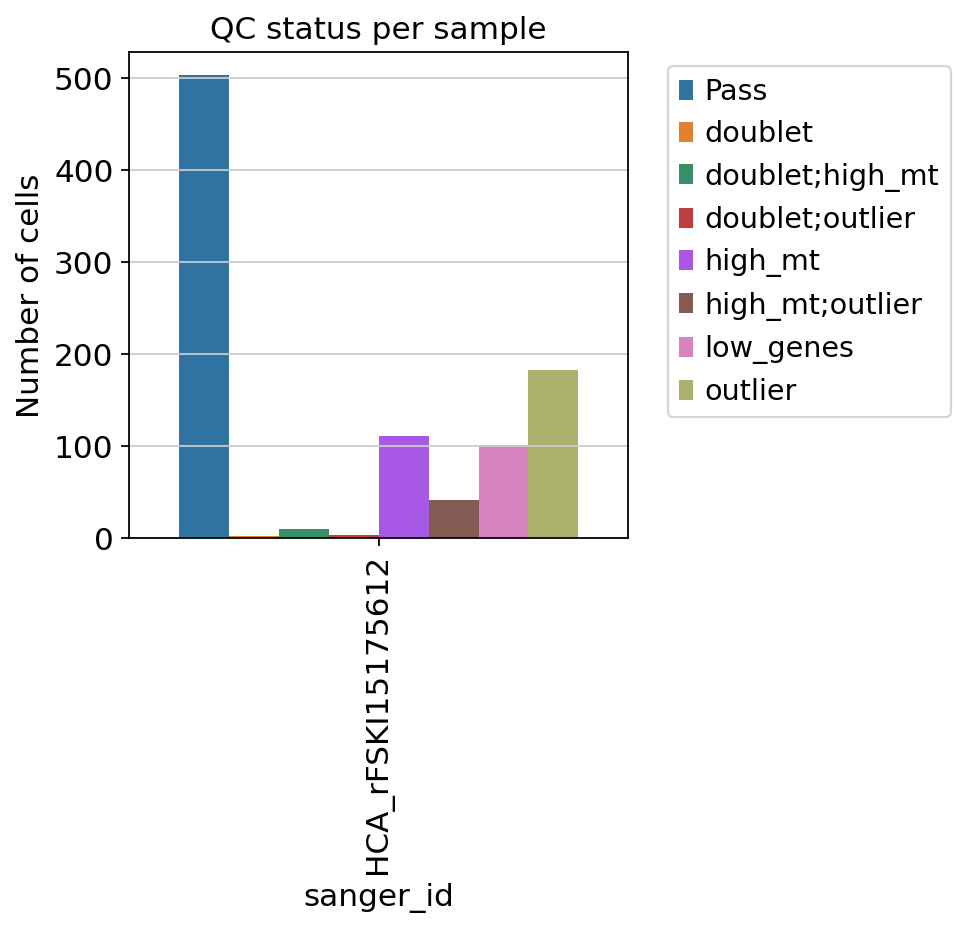

Saved QC status PNG + interactive histogram HTML + Sushi page.


In [109]:
# -------------------------------------------------------
# QC status per sample (Matplotlib for Jupyter)
# -------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.countplot(data=adata_filt.obs, x="sanger_id", hue="QC_reasons", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("Number of cells")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_title("QC status per sample")

plt.show()  # static plot inside Jupyter


# -------------------------------------------------------
# Save Matplotlib PNG
# -------------------------------------------------------
png_path = os.path.join(plot_dir, "qc_status_per_sample.png")
fig.savefig(png_path, dpi=150, bbox_inches="tight")
plt.close(fig)


# -------------------------------------------------------
# Create interactive QC histogram (Plotly) — for HTML only
# -------------------------------------------------------
import plotly.express as px

df = adata_filt.obs.copy()

fig_plotly = px.histogram(
    df,
    x="QC_reasons",
    color="QC_reasons",
    title="QC Reasons Distribution",
    color_discrete_sequence=px.colors.qualitative.Bold,
)

fig_plotly.update_layout(
    xaxis_title="QC Reason",
    yaxis_title="Number of cells",
    legend_title="QC reason",
    bargap=0.2,
    width=900,
    height=500,
)

fig_plotly.update_traces(opacity=1.0)

# ---- IMPORTANT ----
# We DO NOT show Plotly here to keep the notebook clean

# -------------------------------------------------------
# Save interactive HTML for report
# -------------------------------------------------------
plotly_html_path = os.path.join(plot_dir, "qc_reasons_histogram_interactive.html")
fig_plotly.write_html(plotly_html_path)

create_html_page(
    title=f"{sample_id} — QC Reasons Histogram",
    plot_path=plotly_html_path,
    output_dir=report_dir,
    prefix=sample_id,
    plot_type="individual",
)

print("Saved QC status PNG + interactive histogram HTML + Sushi page.")

In [80]:
# # default = "Pass" means everything not caught above is considered good
# adata.obs['QC'] = np.select(conditions, values, default="Pass")

# Normalisation 

In [40]:
adata_filt.layers["counts"] = adata_filt.X.copy()
sc.pp.normalize_total(adata_filt, target_sum=target_sum)

In [41]:
sc.pp.log1p(adata_filt)

In [42]:
adata_filt.raw = adata_filt
adata_filt.layers["logcounts"] = adata_filt.X.copy()

# HVG calculation 

In [43]:
# n_top_genes=2000
sc.pp.highly_variable_genes(adata_filt, n_top_genes=n_top_genes)

In [ ]:
# scaling
# classicially you scale the data
# this is a time consuming step, so is not run now.
#
# sc.pp.scale(adata)

## Dim reduction
### PCA

/software/cellgen/team298/bf16/envs/scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning:

Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None



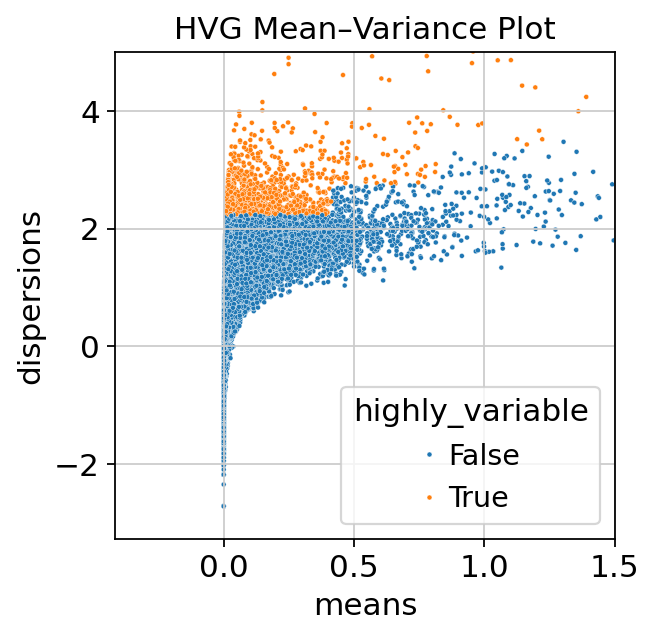

Saved HVG static PNG + interactive HTML + Sushi page.


In [110]:
# -------------------------------------------------------
# HVG mean–variance plot (Matplotlib for Jupyter)
# -------------------------------------------------------

# Run PCA first
sc.pp.pca(adata_filt, use_highly_variable=True, n_comps=n_comps)

fig, ax = plt.subplots()

sns.scatterplot(
    data=adata_filt.var, x="means", y="dispersions", hue="highly_variable", s=5, ax=ax
)

ax.set_xlim(None, 1.5)
ax.set_ylim(None, 5)
ax.set_title("HVG Mean–Variance Plot")

plt.show()  # static version for notebook


# -------------------------------------------------------
# Save Matplotlib PNG
# -------------------------------------------------------
png_path = os.path.join(plot_dir, "hvg_mean_variance.png")
fig.savefig(png_path, dpi=150, bbox_inches="tight")
plt.close(fig)


# -------------------------------------------------------
# HVG Plot — Interactive Plotly version (for HTML)
# -------------------------------------------------------
import plotly.express as px
import pandas as pd

df_var = adata_filt.var.reset_index().rename(columns={"index": "gene"})

fig_plotly = px.scatter(
    df_var,
    x="means",
    y="dispersions",
    color="highly_variable",
    hover_name="gene",
    title="HVG Mean–Variance Plot (Interactive)",
    color_discrete_sequence=px.colors.qualitative.Bold,
)

fig_plotly.update_layout(
    xaxis_title="Mean Expression",
    yaxis_title="Dispersion",
    legend_title="Highly Variable",
    width=900,
    height=600,
)

fig_plotly.update_traces(marker=dict(size=6, opacity=0.9))


# -------------------------------------------------------
# Save interactive version + wrap in Sushi HTML
# -------------------------------------------------------
plotly_html_path = os.path.join(plot_dir, "hvg_mean_variance_interactive.html")
fig_plotly.write_html(plotly_html_path)

create_html_page(
    title=f"{sample_id} — HVG Mean–Variance (Interactive)",
    plot_path=plotly_html_path,
    output_dir=report_dir,
    prefix=sample_id,
    plot_type="individual",
)

print("Saved HVG static PNG + interactive HTML + Sushi page.")

In [45]:
reqCols = ["n_genes_by_counts", "total_counts", "pct_counts_mt"]

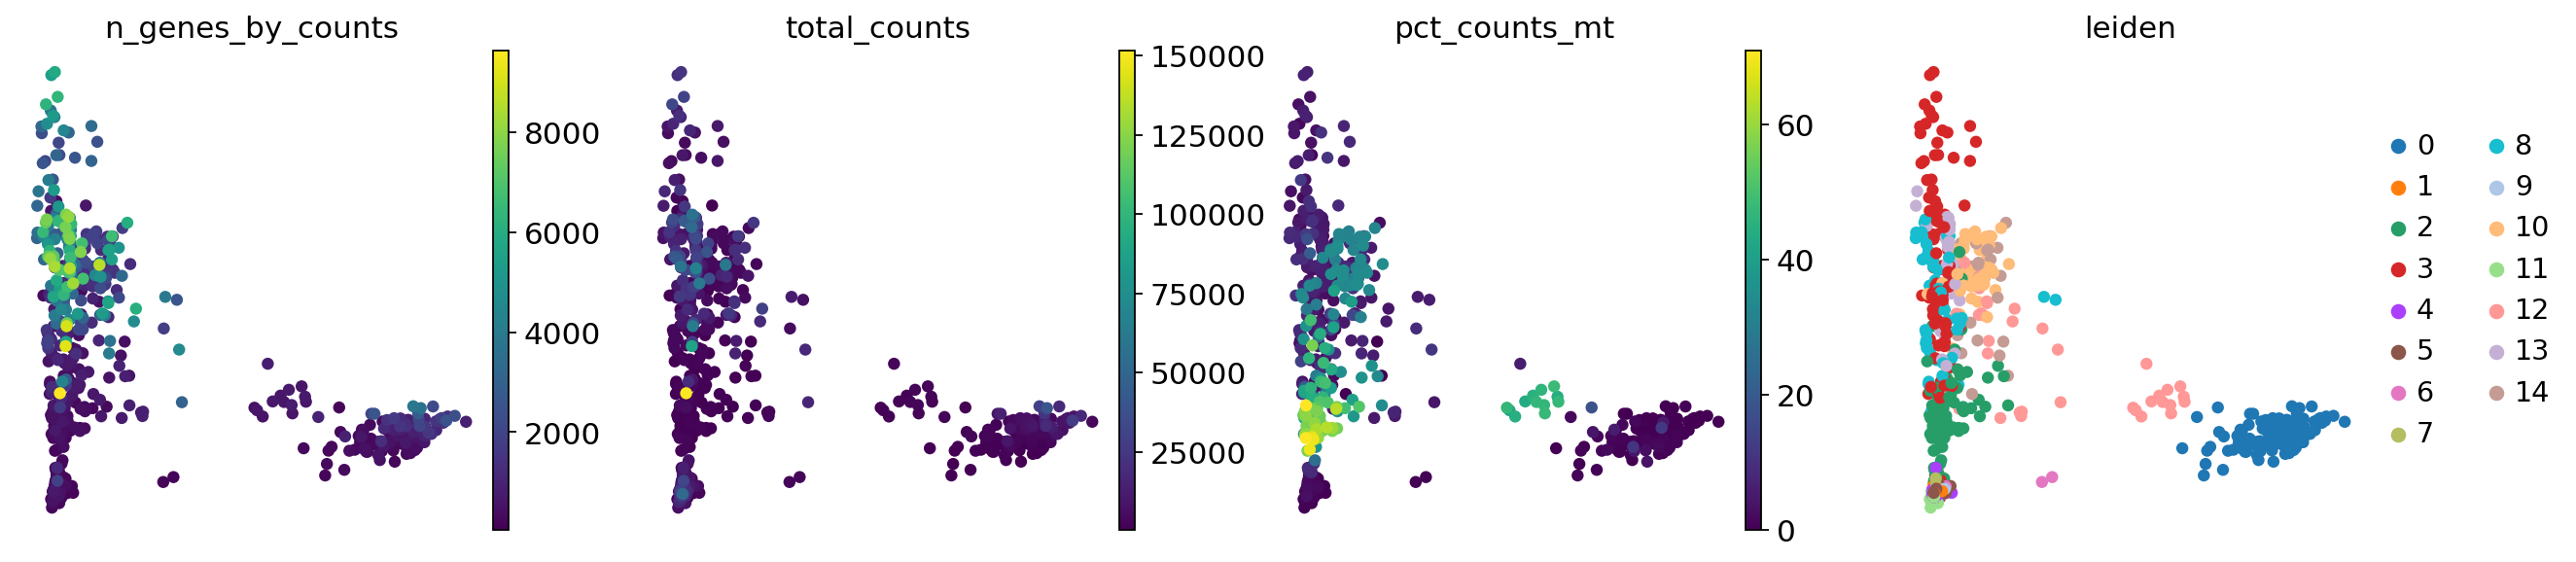

Saved interactive PCA for n_genes_by_counts.
Saved interactive PCA for total_counts.
Saved interactive PCA for pct_counts_mt.
Saved interactive PCA for leiden.


In [111]:
sc.pl.pca_scatter(adata_filt, color=reqCols)


# -------------------------------------------------------
# INTERACTIVE PCA versions (Plotly)
# One per variable in reqCols
# -------------------------------------------------------

import plotly.express as px
import pandas as pd

# Extract PCA coordinates into a DataFrame
pca_df = pd.DataFrame(
    adata_filt.obsm["X_pca"][:, :2], columns=["PC1", "PC2"], index=adata_filt.obs_names
)

# Attach metadata
for col in reqCols:
    pca_df[col] = adata_filt.obs[col].values

for col in reqCols:

    # Choose continuous palette ALWAYS because these are QC numeric vars
    fig_plotly = px.scatter(
        pca_df,
        x="PC1",
        y="PC2",
        color=col,
        hover_name=pca_df.index,
        title=f"PCA Scatter Colored by {col}",
        color_continuous_scale="Cividis",  # or "Viridis" if you prefer
    )

    fig_plotly.update_layout(
        xaxis_title="PC1",
        yaxis_title="PC2",
        width=900,
        height=600,
    )

    fig_plotly.update_traces(marker=dict(size=6, opacity=0.9))

    # Save interactive version
    html_path = os.path.join(plot_dir, f"pca_{col}_interactive.html")
    fig_plotly.write_html(html_path)

    # Wrap in Sushi HTML
    create_html_page(
        title=f"{sample_id} — PCA (colored by {col})",
        plot_path=html_path,
        output_dir=report_dir,
        prefix=sample_id,
        plot_type="individual",
    )

    print(f"Saved interactive PCA for {col}.")

## kNN, clustering and UMAP

In [50]:
sc.pp.neighbors(adata_filt, n_pcs=n_pcs)

In [51]:
sc.tl.leiden(adata_filt, resolution=resolution)

/tmp/ipykernel_3515308/317895462.py:1: FutureWarning:

In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.



## UMAP

In [52]:
sc.tl.umap(adata_filt, min_dist=min_dist, spread=spread)

In [53]:
reqCols.extend(["leiden"])

In [54]:
reqCols

['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'leiden']

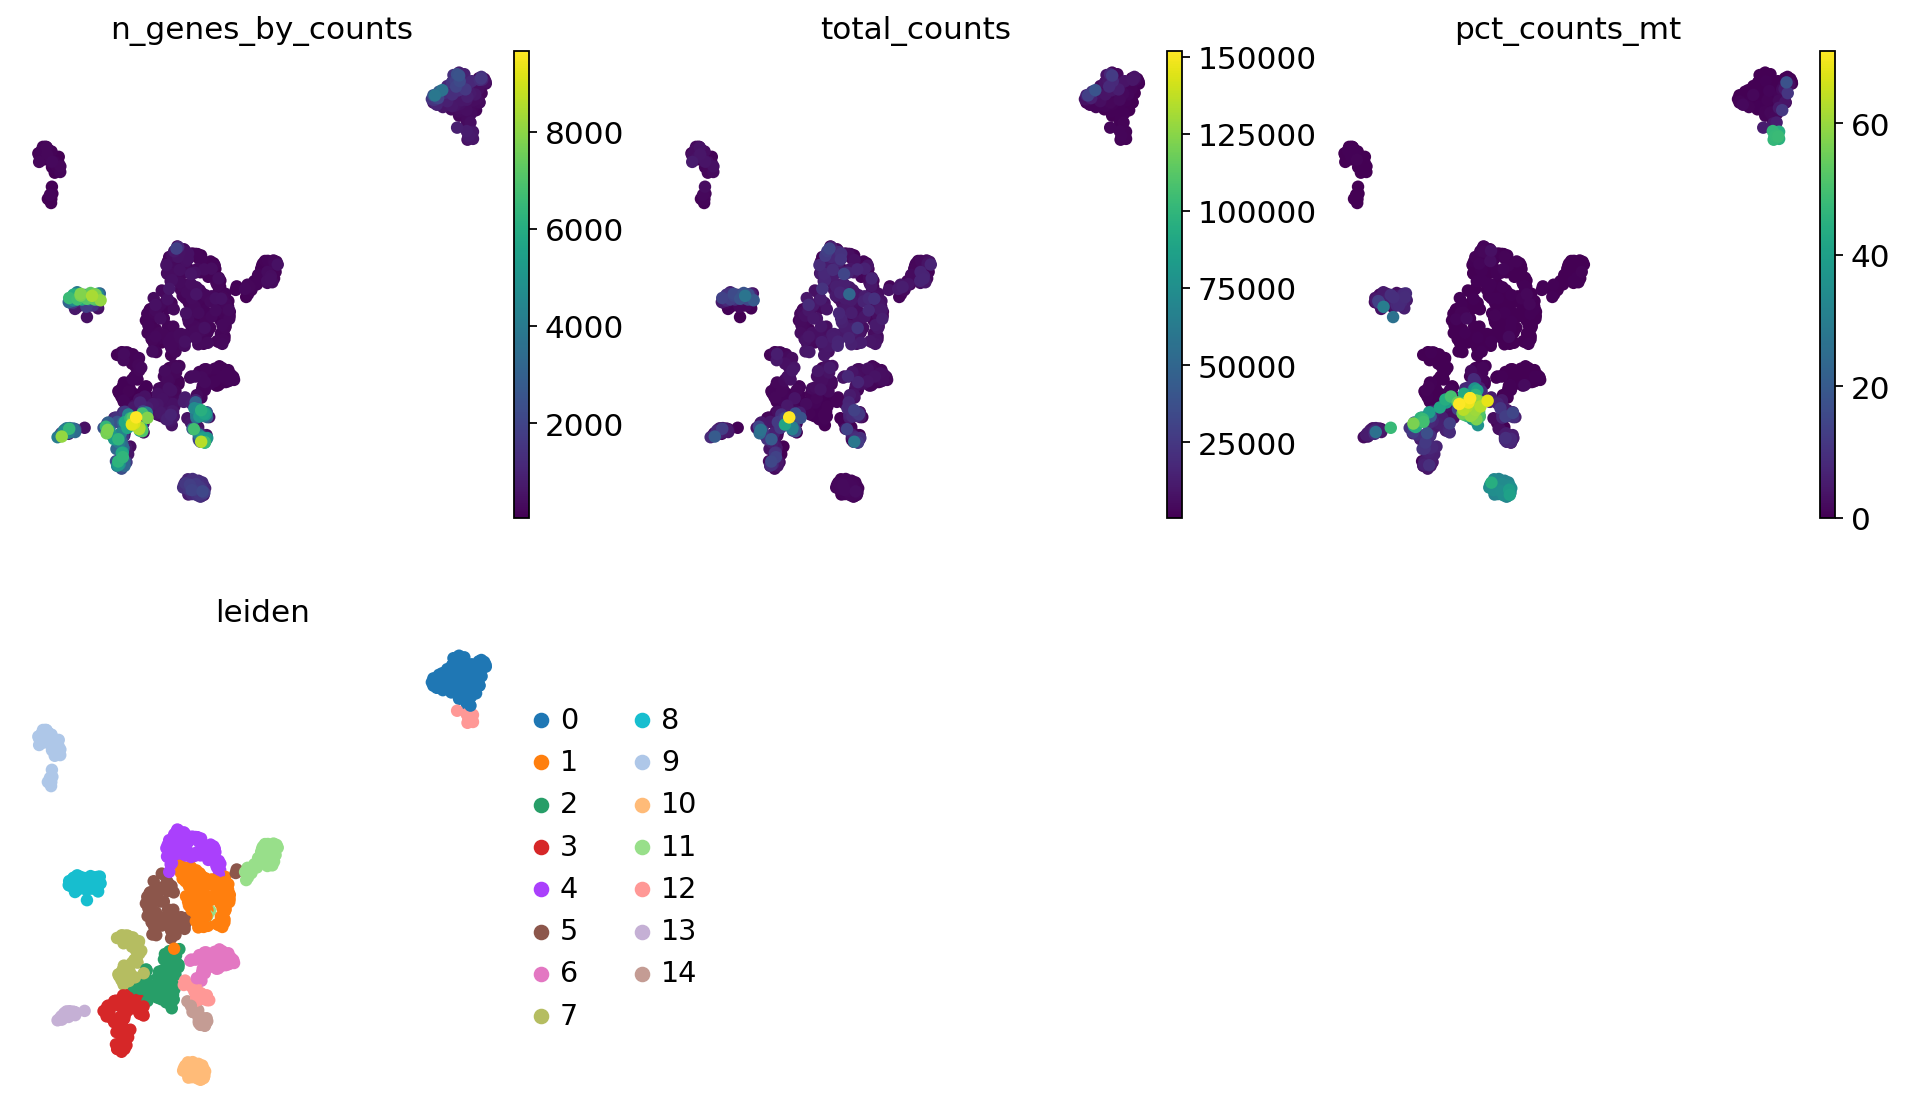

Saved interactive UMAP for: n_genes_by_counts
Saved interactive UMAP for: total_counts
Saved interactive UMAP for: pct_counts_mt
Saved interactive UMAP for: leiden


In [112]:
sc.pl.umap(adata_filt, color=reqCols, ncols=3)

# -------------------------------------------------------
# INTERACTIVE UMAP plots for HTML report
# -------------------------------------------------------
import plotly.express as px
import pandas as pd

# Extract UMAP coordinates
umap_df = pd.DataFrame(
    adata_filt.obsm["X_umap"], columns=["UMAP1", "UMAP2"], index=adata_filt.obs_names
)

# Add metadata for coloring
for col in reqCols:
    umap_df[col] = adata_filt.obs[col].values

# Generate one interactive UMAP per variable
for col in reqCols:

    fig_plotly = px.scatter(
        umap_df,
        x="UMAP1",
        y="UMAP2",
        color=col,
        hover_name=umap_df.index,
        title=f"UMAP Colored by {col}",
        color_continuous_scale="Cividis",
    )

    fig_plotly.update_layout(
        xaxis_title="UMAP 1",
        yaxis_title="UMAP 2",
        width=900,
        height=600,
    )

    fig_plotly.update_traces(marker=dict(size=6, opacity=0.9))

    # Save Plotly HTML
    html_path = os.path.join(plot_dir, f"umap_{col}_interactive.html")
    fig_plotly.write_html(html_path)

    # Wrap into Sushi page
    create_html_page(
        title=f"{sample_id} — UMAP (colored by {col})",
        plot_path=html_path,
        output_dir=report_dir,
        prefix=sample_id,
        plot_type="individual",
    )

    print(f"Saved interactive UMAP for: {col}")

In [113]:
# -------------------------------------------------------
# Build per-sample overview pages + main index page
# -------------------------------------------------------

print(" Building sample overview pages...")
build_sample_pages(report_dir)

print(" Building main index page...")
build_index_page("./reports", project_name="Solosis QC")

print(" QC report successfully generated!")
print(" Open this file in your browser:")
print("   ./reports/index.html")

 Building sample overview pages...
 Created sample overview: HCA_rFSKI15175612__sample_overview.html
 Building main index page...
 QC report successfully generated!
 Open this file in your browser:
   ./reports/index.html


In [ ]:
import os

os.makedirs(outpt_folder_path, exist_ok=True)

In [49]:
adata.write_h5ad(os.path.join(outpt_folder_path, sample_id + ".h5ad"))

In [50]:
adata_filt

AnnData object with n_obs × n_vars = 957 × 38606
    obs: 'sanger_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'doublet_score', 'predicted_doublet', 'predicted_doublet_scrublet', 'predicted_doublet_3MAD', 'predicted_doublet_5MAD', 'outlier', 'outlier_total_counts', 'outlier_genes_counts', 'outlier_pct_counts_mt', 'outlier_pct_counts_ribo', 'outlier_pct_counts_hb', 'QC', 'QC_pass', 'fail_doublet', 'fail_low_counts', 'fail_low_genes', 'fail_high_mt', 'fail_outlier', 'QC_reasons', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_coun